# 24787 (Fall2023) Recitation : Gradient Descent

TA: Sean Chen

## About Gradient Descent
- **Gradient Descent (GD)** is an optimization algorithm that helps to minimize a cost function through repeated steps.

- Simple but powerful idea: In each step, your estimation moves a small step in the direction that minimize the cost **most quickly**.

- Several variants exist: **Stocastic Gradient Descent**, **Mini-Batch Gradient Descent** 

In [21]:
# Import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)
from mpl_toolkits.mplot3d import Axes3D
import time
import math

In [22]:
# Load dataset
# File_path=C:/Users/ADMIN/Desktop/Recitation 3
data = pd.read_csv("sample.csv")

# Print dataset info
print(len(data))

#data.head()

10000


In [23]:
# Cast dataset into matrices and vectors
# Data is set as the dataframe data
y = data.values[:500, 0]
x = data.values[:500, 1:] 
X = np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)

In [24]:
y[:10]

array([1., 1., 1., 1., 0., 0., 0., 1., 0., 0.])

We have X, the input. 500 data each with 16 features + 1 (as a constant term).\
and the expected ground truth Y. 500 data each has 1 ground truth.\
In the example, we want to fit X to y using $\Omega$ in function $Pred$:

\begin{align*}
    {x_{1,1}, x_{1,2}, \ldots, x_{500,17}} = X &\in \mathbb{R}^{500 \times 17} \text{ (Feature matrix)} \\
    {y_1, y_2, \ldots, y_{500}} = Y &\in \mathbb{R}^{500} \text{ (Ground truth vector with binary values)} \\
    {\omega_1, \omega_2, \ldots, \omega_{17}} = \Omega &\in \mathbb{R}^{17} \text{ (Parameter vector)}
\end{align*}

\begin{equation}
    \underset{\Omega}{\arg\min}Loss({Y, Pred(X; \Omega)})
\end{equation}




We want to find the best omega (17 parameters) later, 
such that the loss(difference) between the predictions and labels can be minimized.\

In [25]:
print(X.shape)
print(y.shape)
print(x.shape)

(500, 17)
(500,)
(500, 16)


Define a function for obtaining the sigmoid. This will be used for the prediction step in gradient descent.
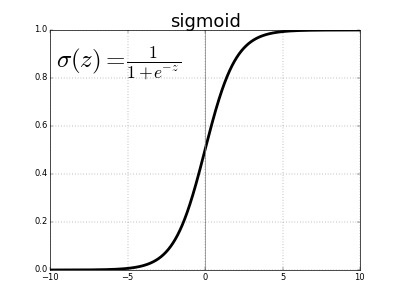

In this case, we use a **weighted sum + a sigmoid** $(\sigma)$ layer as the prediction function:

\begin{equation}
    Pred(X; \Omega)=\sigma(\Omega \cdot X)
\end{equation}

And **Binary Cross Entropy (BCE)** as the **loss function**:

\begin{equation}
    BCELoss({Y, Pred(X; \Omega)})=\sum_{x,y \in X,Y} -y \cdot log(Pred(x; \Omega)) -(1-y) \cdot log(1-Pred(x; \Omega))
\end{equation}

Therefore, the Objective became:
\begin{equation}
    \underset{\Omega}{\arg\min}\sum_{x,y \in X,Y} -y \cdot log(\sigma(\Omega \cdot X)) -(1-y) \cdot log(1-\sigma(\Omega \cdot X))
\end{equation}

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [27]:
def loss_fn(y, y_pred):
#     N, M = X.shape
    # cross entropy (adding up all N samples)
    cross_entropy = -(np.log(y_pred[y == 1]).sum() + np.log(1 - y_pred[y == 0]).sum())
    return cross_entropy 

Create a function ***gradient_fn*** that calculates the gradient with respect to the weights.

$$ \frac{\partial{L}}{\partial{\omega_j}} = \frac{1}{N} \sum_{i=1}^N ({\sigma}_i-y_i){\cdot}x_{i,j} $$
$ N= 1 $: stochastic gradient descent\
$ N= 2-499 $: mini batch gradient descent\
$ N= 500 $: batch gradient descent



The gradient can be derived using **chain rule**, and [**derivative of Sigmoid**](https://hausetutorials.netlify.app/posts/2019-12-01-neural-networks-deriving-the-sigmoid-derivative).\
    For simplification, we derive the gradient for stochastic descent from data point $x_i$ on variable $\omega_j$:
    
$$L_{i,j}=-y_i \cdot log(\sigma(\omega_{j} \cdot x_{i,j})) -(1-y_i) \cdot log(1-\sigma(\omega_j \cdot x_{i,j}))$$
$$ \frac{\partial{L}}{\partial{\omega_j}} =
\frac{\partial{L}}{\partial{\sigma(\omega_j x_{i,j})}}
\frac{\partial{\sigma(\omega_j x_{i,j})}}{\partial{\omega_j \cdot x_{i,j}}}
\frac{\partial{\omega_j \cdot x_{i,j}}}{\partial{\omega_j}}
$$

$$
\frac{\partial{L_{i,j}}}{\partial{w_j \cdot x_{i,j}}}=
\frac{-y_i}{\sigma(\omega_j \cdot x_{i,j})}+\frac{1-y_i}{1-\sigma(\omega_j \cdot x_{i,j})} =
\frac{\sigma(\omega_j \cdot x_{i,j})-y_i}{\sigma (\omega_j \cdot x_{i,j}) \cdot (1-\sigma (\omega_j \cdot x_{i,j}))}
$$



$$
\frac{\partial{\sigma(\omega_j x_{i,j})}}{\partial{\omega_j \cdot x_{i,j}}}
=\sigma(\omega_j x_{i,j}) \cdot (1-\sigma(\omega_j x_{i,j}))
$$

$$
\frac{\partial{\omega_j \cdot x_{i,j}}}{\partial \omega_j} = x_{i,j}
$$

$$
\rightarrow \mathbf{\frac{\partial{L}}{\partial{\omega_j}} = ({\sigma}_i-y_i){\cdot}x_{i,j}}
$$

In [28]:
def gradient_fn(X, y, y_pred):
#     N, M = X.shape
    # we use y_pred here since it is the sigmoid of X and the weights
    grad = -np.dot(y - y_pred, X)
    return grad   

Create a function ***predict_fn*** that returns a class prediction of the samples given the weights. Sigmoid returns a value between 0 and 1 which is tells us which class (0 or 1) the sample most likely belongs to.

In [29]:
def predict_fn(X, omega):
    return sigmoid(np.dot(X, omega))

**Batch Gradient Descent** updates the weights once per epoch after going through all of the samples. 

***gradient_descent*** performs gradient descent with the following parameters.
- **X:** arrays containing the sample data
- **y:** array containing the ground truth classification of the samples (their label)
- **omega:** an initial weights matrix (we'll start with random weights, but there are techniques for choosing initial weights)
- **lr:** learning rate
- **max_iter:** maximum number of iterations to run the gradient descent update 
- **tol:** a specified tolerance for convergence

In [30]:
# The batch/normal gradient descent
def gradient_descent(X, y, omega, lr=1e-4, max_iter=1e6, tol=5e-7):
    
    N, M = X.shape
    
    # placeholder for loss
    loss_history = []
    
    l_prev = np.inf
    for iteration in range(int(max_iter)):
        # make classification predictions based on our model weights (omega)
        y_pred = predict_fn(X, omega)
        
        # solve for the normalized loss
        loss = loss_fn(y, y_pred) / N
        if l_prev - loss < tol:
            print("Loss converged at iteration %d, loss %0.3f" %(iteration, loss))
            return omega, loss_history, iteration
        l_prev = loss 
        loss_history.append(loss) 

        # update weight (omega)
        omega -= lr * gradient_fn(X, y, y_pred) / N

        # print results
        if iteration % 1e4 == 1: 
            print("Training at iteration %d, loss %0.3f" %(iteration, loss))
    
    return omega, loss_history, iteration


Training at iteration 1, loss 2.606
Training time per 100 iteration 0.005 second
Accuracy is 0.70 


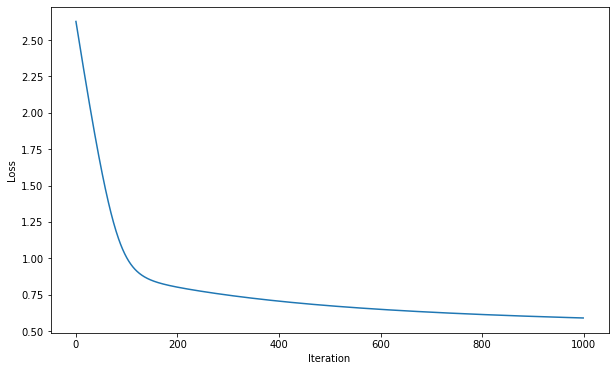

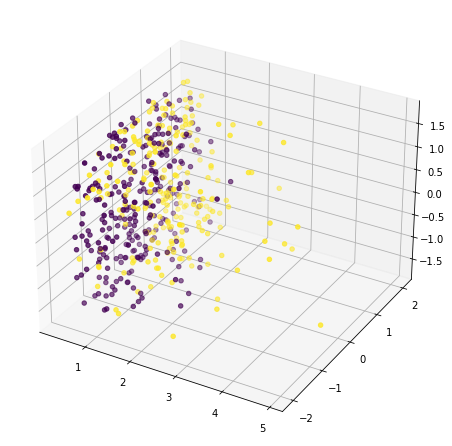

In [31]:
# concatenate "one" column
N, M = X.shape

# initial weights
np.random.seed(10)
omega = np.random.rand(M)

# train
start = time.time()
new_omega, loss_history, iteration = gradient_descent(X, y, omega, 1e-2, 1e3)
print("Training time per 100 iteration %.3f second" %(((time.time() - start) / iteration) * 100))

# plot_loss
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(np.arange(len(loss_history)), loss_history)

# use the final model weights to predict the sample classifications
Y_predict = predict_fn(X, new_omega)
Y_predict[np.where(Y_predict > 0.5)] = 1
Y_predict[np.where(Y_predict < 0.5)] = 0 

# print accuracy
count = 0
for i in range(Y_predict.shape[0]):
    count += int(Y_predict[i] == y[i])
print("Accuracy is %0.2f " %(float(count) / Y_predict.shape[0]))

# plot prediction
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 1], X[:, 2], X[:, 3], c=Y_predict)
plt.show()

**Stochastic Gradient Descent** updates the weights of the network at each sample.

In [32]:
# The stocastic gradient descent
def SGD(X, y, omega, lr=1e-4, max_iter=1e6, tol=5e-7):
    
    N, M = X.shape
    loss_history = []
    
    for iteration in range(int(max_iter)):
        
        # generate one random sample - that's why it's called stocastic 
        idx = np.random.randint(N)
        X_sample = X[[idx], :]
        y_sample = y[[idx]]
        y_pred = predict_fn(X_sample, omega)

        # update weight
        omega -= lr * gradient_fn(X_sample, y_sample, y_pred) / 1 # divided by 1 because we only have 1 sample
        
        loss = loss_fn(y, sigmoid(np.dot(X, omega))) / N
        loss_history.append(loss) 

    return omega, loss_history, iteration

Training time per 100 iteration 0.006 second
Accuracy is 0.70 


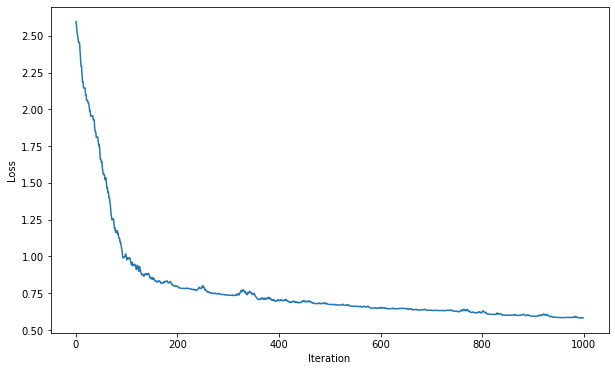

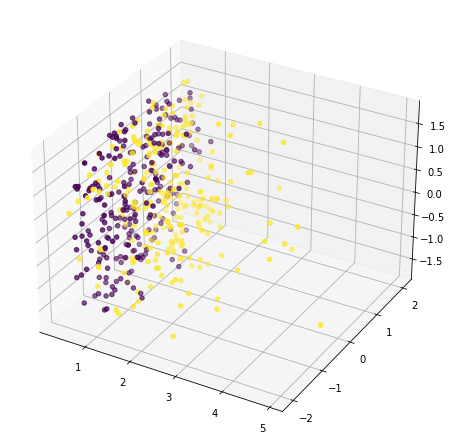

In [33]:
# concatenate "one" column
N, M = X.shape

# initial weights
np.random.seed(10)
omega = np.random.rand(M)

# train using SGD
# The loss is smaller, but spend longer time
start = time.time()
new_omega, loss_history, iteration = SGD(X, y, omega, 1e-2, 1e3, 1e-6)
print("Training time per 100 iteration %.3f second" %((time.time() - start) / iteration * 100))

# plot_loss
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(np.arange(len(loss_history)), loss_history)

# predict 
Y_predict = predict_fn(X[:], new_omega)
Y_predict[np.where(Y_predict > 0.5)] = 1
Y_predict[np.where(Y_predict < 0.5)] = 0

# print accuracy
count = 0
for i in range(Y_predict.shape[0]):
    count += int(Y_predict[i] == y[i])
print("Accuracy is %0.2f " %(float(count) / Y_predict.shape[0]))

# plot prediction
fig2 = plt.figure()
ax1 = Axes3D(fig2)
ax1.scatter(X[:, 1], X[:, 2], X[:, 3], c=Y_predict)
plt.show()

**Mini-Batch Gradient Descent** updates the weights of the network after a *batch size* number of samples have been processed. The batch size is a tunable hyperparameter that can be changed to improve performance.

In [34]:
# The mini-batch gradient descent 
def mini_batch(X, y, omega, lr=1e-4, max_iter=1e6, tol=5e-7, batch_size=20):
    
    N, M = X.shape
    loss_history = []
    
    # placeholder for loss
    l_prev = np.inf
    for iteration in range(int(max_iter)):
        idx = np.random.randint(0,N,[batch_size])

        X_sample = X[idx, :]
        y_sample = y[idx]
        y_pred = predict_fn(X_sample, omega)

        # update weight
        omega -= lr * gradient_fn(X_sample, y_sample, y_pred) / batch_size
        
        loss = loss_fn(y, sigmoid(np.dot(X, omega))) / N
        loss_history.append(loss) 
        l_prev = loss
        
        # print results
        if iteration % 1e5 == 1: 
            print("Training at iteration %d, loss %0.3f" %(iteration, loss / batch_size))
    
    return omega, loss_history, iteration

Training at iteration 1, loss 0.000
Training time per 100 iteration 0.059 second
Accuracy is 0.70 


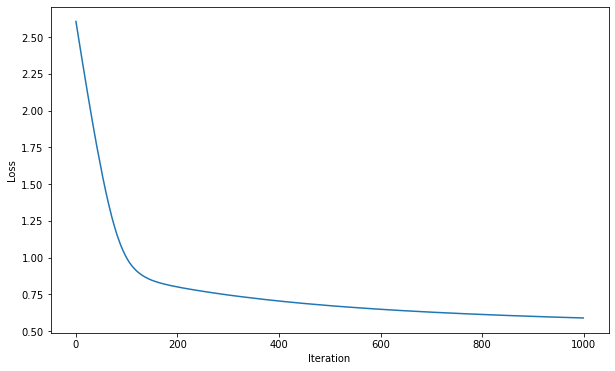

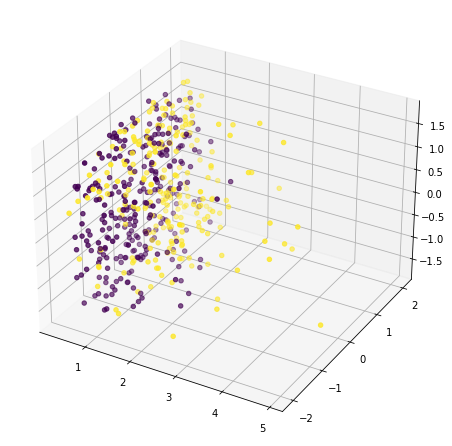

In [35]:
# concatenate "one" column
N, M = X.shape

# initial weights
np.random.seed(10)
omega = np.random.rand(M)

# train using SGD
# The loss is smaller, but spend longer time
start = time.time()
new_omega, loss_history, iteration = mini_batch(X, y, omega, 1e-2, 1e3, 1e-6, 10000)
print("Training time per 100 iteration %.3f second" %((time.time() - start) / iteration * 100))

# plot_loss
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(np.arange(len(loss_history)), loss_history)

# predict 
Y_predict = predict_fn(X[:], new_omega)
Y_predict[np.where(Y_predict > 0.5)] = 1
Y_predict[np.where(Y_predict < 0.5)] = 0

# print accuracy
count = 0
for i in range(Y_predict.shape[0]):
    count += int(Y_predict[i] == y[i])
print("Accuracy is %0.2f " %(float(count) / Y_predict.shape[0]))

# plot prediction
fig3 = plt.figure()
ax2 = Axes3D(fig3)
ax2.scatter(X[:, 1], X[:, 2], X[:, 3], c=Y_predict)
plt.show()

## References

A nice visualization of GD, SGD and Mini-Batch: http://www.deeplearning.ai/ai-notes/optimization/